# **Fluxograma apresentado no paper**




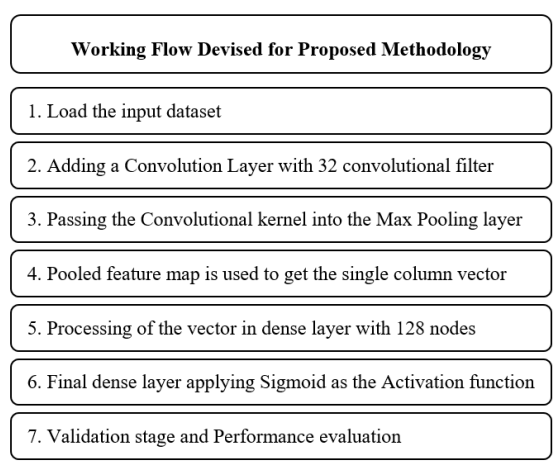

# **Upload do Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# aparentemente a localização não muda
!cd ./drive/Shareddrives/PDI\ DataSet
!ls ./

drive  sample_data


In [ ]:
# só precisa executar 1 vez
!unzip ./drive/Shareddrives/PDI\ DataSet/archive.zip

Archive:  ./drive/Shareddrives/PDI DataSet/archive.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  

In [ ]:
! ls ./ # o resultado do unzip foi parar do lado dos aquivos padrão

'Brain Tumor Data Set'	 metadata.csv		 sample_data
 drive			 metadata_rgb_only.csv


# **Código**

## **Imports**

In [ ]:
import pandas as pd
#from sklearn.model_selection import train_test_split # função para fazer split dos dados
import tensorflow as tf
import os
import cv2
from google.colab.patches import cv2_imshow # patch de update para mostrar imagens
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm_notebook as tqdm # barra de progressão (opcional)
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import InputLayer, MaxPool2D, Flatten, Dense, Conv2D
from keras.models import Sequential

In [ ]:
path = "./Brain Tumor Data Set/Brain Tumor Data Set/"
listaSaudaveis = os.listdir(path+"Healthy") # lista com o nome dos arquivos
listaNaoSaudaveis = os.listdir(path+"Brain Tumor")

In [ ]:
(listaSaudaveis[0])

'Not Cancer  (1165).jpg'

In [ ]:
 !ls

'Brain Tumor Data Set'	 metadata.csv		 sample_data
 drive			 metadata_rgb_only.csv


## **Imagens sem tumor**

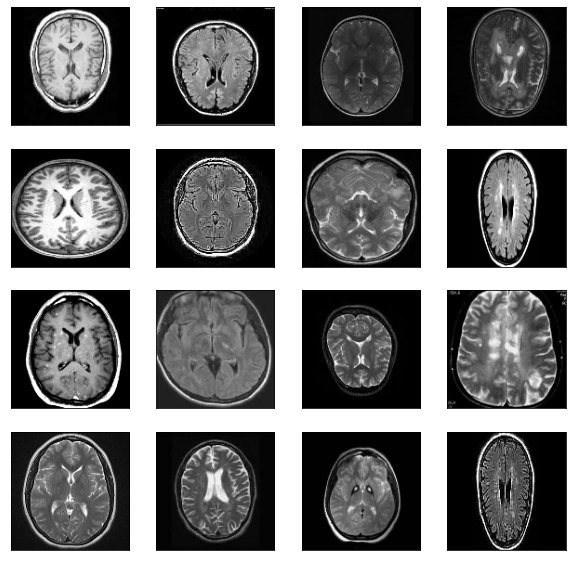

In [ ]:
#dfInput1 = []
plt.figure(figsize=(10,10)) # tamanho de cada 
for i,foto in enumerate(listaSaudaveis[0:16]):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = cv2.imread(path+"Healthy/"+foto)
  img = cv2.resize(img,(128,128))
  plt.imshow(img,cmap=plt.cm.binary)
  #cv2_imshow(img)
  #dfInput1.append([img,1]) # 1 vai corresponder a categoria saudavel

## **Imagens com tumor**

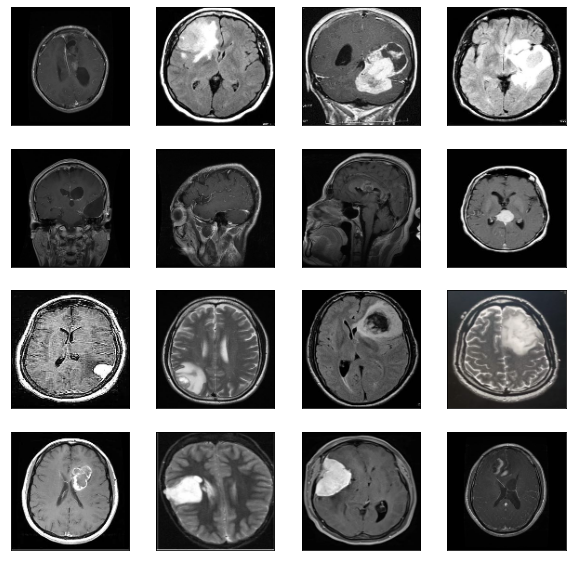

In [ ]:
plt.figure(figsize=(10,10)) # tamanho de cada 
for i,foto in enumerate(listaNaoSaudaveis[0:16]):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = cv2.imread(path+"Brain Tumor/"+foto)
  img = cv2.resize(img,(128,128))
  plt.imshow(img,cmap=plt.cm.binary)

## **Pré-Processamento dos Dados**

In [ ]:
# Reescala pois é utiliizado RGB a fim de ganhar mais informação da imagem
# Separa 20% do total de dados
generation = ImageDataGenerator(rescale=1./255, validation_split = 0.2, zoom_range = (0.99, 0.99), dtype=tf.float32 )

In [ ]:
# Base de dados para treinamento
train = generation.flow_from_directory(path,
                                      target_size = (64,64),
                                      batch_size = 32, #numero de imagens por lote
                                      class_mode = "binary",
                                      color_mode = "rgb",
                                      shuffle = True,
                                      seed = 123,
                                      subset = "training")

Found 3681 images belonging to 2 classes.


In [ ]:
train.image_shape

(64, 64, 3)

In [ ]:
classes_train = train.class_indices
classes_train

{'Brain Tumor': 0, 'Healthy': 1}

In [ ]:
#Base de dados para validação

validation = generation.flow_from_directory(path,
                                            target_size = (64,64),
                                            batch_size = 8,
                                            class_mode = "binary",
                                            color_mode = "rgb",
                                            shuffle = True,
                                            seed = 123,
                                            subset = "validation")

Found 919 images belonging to 2 classes.


In [ ]:
classes_validation = validation.class_indices
classes_validation

{'Brain Tumor': 0, 'Healthy': 1}

## **Plots da divisão de dados**

In [ ]:
import seaborn as sns

In [ ]:
def plotByBase(dataBase):
  t=0
  h=0
  for i in range(len(dataBase)):
      (a, b) = next(dataBase)
      for j in b:
          if j == 1:
            h+=1
          else:
            t+=1

  sns.barplot(x=['tumor','healty'],y=[t,h])

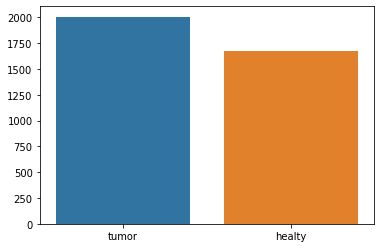

In [ ]:
#Verificando os dados da base de treinamento

plotByBase(train)

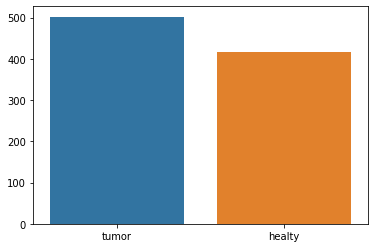

In [ ]:
#Verificado os dados da base de validação

plotByBase(validation)

## **Cronstrução do Modelo**

### **Montando as Camadas**

In [ ]:
model = keras.Sequential([
  InputLayer(input_shape=(64, 64, 3)),
  Conv2D( filters=32, kernel_size=(3, 3), activation="relu"),
  MaxPool2D( pool_size=(2, 2) ),
  Flatten( input_shape=(31, 31, 32) ),
  Dense( 128, activation="relu" ),
  Dense( 1, activation="sigmoid" )
])

### **Compilando o Modelo**

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense (Dense)               (None, 128)               3936384   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
______________________________________________

### **Treinamento do Modelo Criado**

In [ ]:
# O fit é atribuido a history somente para recuperar os valores de acuracia e epocas correspondentes
history = model.fit(train, 
          epochs=10,
          steps_per_epoch = 80, #numeros de lotes treinados por epoca
          validation_data=validation)

Epoch 1/10
80/80 [==============================] - 22s 260ms/step - loss: 0.5959 - accuracy: 0.7293 - val_loss: 0.3724 - val_accuracy: 0.8346
Epoch 2/10
80/80 [==============================] - 21s 259ms/step - loss: 0.2993 - accuracy: 0.8816 - val_loss: 0.2592 - val_accuracy: 0.8923
Epoch 3/10
80/80 [==============================] - 21s 258ms/step - loss: 0.1879 - accuracy: 0.9359 - val_loss: 0.1608 - val_accuracy: 0.9478
Epoch 4/10
80/80 [==============================] - 20s 255ms/step - loss: 0.1180 - accuracy: 0.9624 - val_loss: 0.2242 - val_accuracy: 0.9053
Epoch 5/10
80/80 [==============================] - 21s 257ms/step - loss: 0.0772 - accuracy: 0.9754 - val_loss: 0.1382 - val_accuracy: 0.9489
Epoch 6/10
80/80 [==============================] - 20s 253ms/step - loss: 0.0650 - accuracy: 0.9810 - val_loss: 0.0868 - val_accuracy: 0.9728
Epoch 7/10
80/80 [==============================] - 20s 255ms/step - loss: 0.0395 - accuracy: 0.9917 - val_loss: 0.0635 - val_accuracy: 0.9804

### **Calculando acurácia**

In [ ]:
test_loss, test_acc = model.evaluate(validation, verbose=1) # validation é o conjunto de teste
print('\nTest accuracy:', test_acc)                         # O teste é feito em uma epoca contendo 115 lotes x 8(numero de imagens por lote) totalizando 919 imagens
print('\nTest Loss:', test_loss)

115/115 [==============================] - 4s 38ms/step - loss: 0.0410 - accuracy: 0.9880

Test accuracy: 0.9880304932594299

Test Loss: 0.040968168526887894


# **Plot das acuracias**

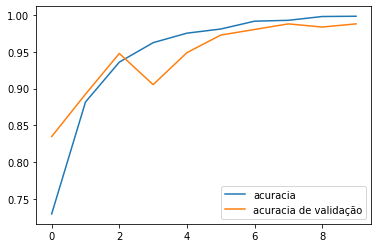

In [ ]:
plt.plot(history.epoch,history.history.get("accuracy"),label="acuracia")
plt.plot(history.epoch,history.history.get("val_accuracy"),label="acuracia de validação")
plt.legend(loc='lower right')

# **Plot do Loss**

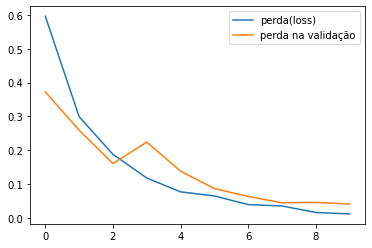

In [ ]:
plt.plot(history.epoch,history.history.get("loss"),label="perda(loss)")
plt.plot(history.epoch,history.history.get("val_loss"),label="perda na validação")
plt.legend(loc='upper right')